<div align="center" style="font-weight: bold; color:#fbb900">
    <div style="font-size: xx-large">Grado en Ingeniería Matemática e Inteligencia Artificial(iMAT)</div><br>
    <div style="font-size: x-large; color:gray">Tecnologia de Procesamiento de Big Data&ndash; SPARK</div><br>
    <div style="font-size: large; color:gray">Elena Ardura Carnicero, Victoria García Martínez-Echevarría y Jimena Monteagudo Ruiz</div><br>
        <div style="font-size: large; color:gray">Escuela Técnica Superior de Ingeniería (ICAI)</div><br>
</div>

In [42]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import math
import pandas as pd
import subprocess
import plotly.express as px

from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (StringIndexer,
                                OneHotEncoder,
                                PCA,
                                PolynomialExpansion,
                                Tokenizer,
                                HashingTF,
                                VectorAssembler,
                                StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.pipeline import Pipeline


from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import PolynomialExpansion, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.sql.functions import desc, row_number, dense_rank
from pyspark.sql.functions import lag, col

In [43]:
%%html
<style>
    .qst, .slides {background-color: #fbb900; padding:10px; border-radius: 5px; border: solid 2px #fbb900;}
    .qst:before, .slides:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color:  #fbb900;}
    .text_cell_render p, ul, ol {text-align: justify; text-justify: inter-word;}
    li {margin-bottom: 10px; margin-top: 10px;}
    div.output pre{border: 1px solid gray; border-radius: 1px; padding: 5px}
    td, th {font-size: 110%;}
</style>

In [44]:
user = 'abd23'
appName = user+'_final_sprint'
spark = SparkSession.builder.master("yarn") \
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [45]:
if not (("sc" in globals()) or ("sc" in locals())):
    sc = pyspark.SparkContext()

print(sc)

<SparkContext master=yarn appName=abd23_final_sprint>


In [46]:
sc

<SparkContext master=yarn appName=abd23_final_sprint>

## Procesado de los datos

In [78]:
spark.sql("USE real_estate")
df = spark.sql("SELECT * from data LIMIT 100")
df.show()

+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|      Date|              Open|              High|               Low|             Close|   Volume|Dividends|StockSplits|Symbol|       CIK|
+----------+------------------+------------------+------------------+------------------+---------+---------+-----------+------+----------+
|2020-01-02|142.98894185962598|143.42163110894384|139.97782189668848|141.04627990722656|1094900.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-03| 139.9601258223185|142.48558983037347| 139.9601258223185| 141.8498077392578| 371300.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-06|141.32002513294364|142.67989801099486|140.92266458118684|142.19422912597656| 604700.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-07| 138.1852552232042|139.10359973486672|136.60462528551435|137.54063415527344|4543900.0|      0.0|        0.0|   ARE|0001035443|
|2020-01-08|138.19406930717

In [79]:
data = spark.sql("SELECT date, open, low, close, volume, high, symbol FROM data ORDER BY date")
data.show(5)

+----------+------------------+------------------+------------------+---------+------------------+------+
|      date|              open|               low|             close|   volume|              high|symbol|
+----------+------------------+------------------+------------------+---------+------------------+------+
|2018-01-02|124.80659876477053|122.84505336076565|123.03684997558594|1880600.0|124.85890451379768|   AMT|
|2018-01-02|145.44780653419463|144.15287689375694| 144.3483428955078| 594800.0|145.94460508159082|   AVB|
|2018-01-02|109.16297439886733|108.06300550008864|108.27133178710938| 540100.0|109.16297439886733|   ARE|
|2018-01-02| 43.68000030517578|  43.2400016784668| 43.81999969482422|2389400.0| 43.83000183105469|  CBRE|
|2018-01-02| 101.5064510419608|100.33872593055914|  100.642333984375| 690000.0| 101.5064510419608|   BXP|
+----------+------------------+------------------+------------------+---------+------------------+------+
only showing top 5 rows



In [80]:
data = data.filter(F.col("symbol") == "ARE")
data.show()

+----------+------------------+------------------+------------------+---------+------------------+------+
|      date|              open|               low|             close|   volume|              high|symbol|
+----------+------------------+------------------+------------------+---------+------------------+------+
|2018-01-02|109.16297439886733|108.06300550008864|108.27133178710938| 540100.0|109.16297439886733|   ARE|
|2018-01-03| 108.4546631096008|107.42970130773858|107.76303100585938| 470000.0|108.55466837665097|   ARE|
|2018-01-04|104.46313172318115| 104.3297998505763|105.61309051513672|2719600.0|107.00471491559198|   ARE|
|2018-01-05|105.74641319731155|105.60475286319082|105.82974243164062|1075600.0|106.56304859439476|   ARE|
|2018-01-08| 106.1380653348256|105.68807984988264|106.06306457519531| 919000.0|106.81303402582066|   ARE|
|2018-01-09|106.02972346442499|105.06309299732713| 105.2630844116211| 865800.0|106.08805455849458|   ARE|
|2018-01-10|105.23810141453016|103.72982122409

### Añadimos el Lag

In [81]:
windowSpec = Window.partitionBy("symbol").orderBy("date")

for feature in ["open", "close", "low", "volume", "high"]:
    data = data.withColumn(f"{feature}_prev_day", lag(df[feature]).over(windowSpec))

data = data.filter(col("open_prev_day").isNotNull())
data.show()

+----------+------------------+------------------+------------------+---------+------------------+------+------------------+------------------+------------------+---------------+------------------+
|      date|              open|               low|             close|   volume|              high|symbol|     open_prev_day|    close_prev_day|      low_prev_day|volume_prev_day|     high_prev_day|
+----------+------------------+------------------+------------------+---------+------------------+------+------------------+------------------+------------------+---------------+------------------+
|2018-01-03| 108.4546631096008|107.42970130773858|107.76303100585938| 470000.0|108.55466837665097|   ARE|109.16297439886733|108.27133178710938|108.06300550008864|       540100.0|109.16297439886733|
|2018-01-04|104.46313172318115| 104.3297998505763|105.61309051513672|2719600.0|107.00471491559198|   ARE| 108.4546631096008|107.76303100585938|107.42970130773858|       470000.0|108.55466837665097|
|2018-01-0

### Dividimos el dataset en train y test

In [82]:
windowSpec = Window.partitionBy('symbol').orderBy(desc('date'))

data_with_rank = data.withColumn('rank', dense_rank().over(windowSpec))

total_rows_by_symbol = data_with_rank.groupBy('symbol').count()

test_data = data_with_rank.join(total_rows_by_symbol, 'symbol').where('rank <= 7').drop('rank', 'count')
train_data = data_with_rank.join(total_rows_by_symbol, 'symbol').where('rank > 7').drop('rank', 'count')

In [83]:
train_data.show(3)

+------+----------+------------------+------------------+------------------+--------+------------------+------------------+------------------+------------------+---------------+------------------+
|symbol|      date|              open|               low|             close|  volume|              high|     open_prev_day|    close_prev_day|      low_prev_day|volume_prev_day|     high_prev_day|
+------+----------+------------------+------------------+------------------+--------+------------------+------------------+------------------+------------------+---------------+------------------+
|   ARE|2024-04-15|123.51000213623047|118.41999816894531|119.18000030517578|572800.0| 123.8499984741211| 123.5999984741211|121.83999633789062|121.23999786376953|       535300.0|123.62000274658203|
|   ARE|2024-04-12| 123.5999984741211|121.23999786376953|121.83999633789062|535300.0|123.62000274658203|123.83000183105469| 123.9000015258789|121.87999725341797|       691600.0|124.69999694824219|
|   ARE|2024-04

### Columnas

In [84]:
features = ['open', 'close', 'low', 'volume', 'high']
assembler = VectorAssembler(inputCols=[f'{feature}_prev_day' for feature in features], outputCol="features")

## Modelo Linear Regression Generalizado

### Modelo

In [59]:
glr = GeneralizedLinearRegression(featuresCol="features", labelCol="close")

In [60]:
pipeline = Pipeline(stages=[assembler, glr])

paramGrid = ParamGridBuilder() \
    .addGrid(glr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(glr.family, ["gaussian", "tweedie", "poisson"]) \
    .build()

evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

glrModel = crossval.fit(train_data_glr)

test_predictions_glr = glrModel.transform(test_data_glr)

24/04/25 18:12:55 ERROR MapOutputTrackerMaster: head of empty list              
java.util.NoSuchElementException: head of empty list
	at scala.collection.immutable.Nil$.head(List.scala:469)
	at scala.collection.immutable.Nil$.head(List.scala:466)
	at org.apache.spark.MapOutputTrackerMaster$MessageLoop.handleStatusMessage(MapOutputTracker.scala:737)
	at org.apache.spark.MapOutputTrackerMaster$MessageLoop.run(MapOutputTracker.scala:763)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
24/04/25 18:13:54 ERROR MapOutputTrackerMaster: head of empty list21 + 6) / 200]
java.util.NoSuchElementException: head of empty list
	at scala.collection.immutable.Nil$.head(List.scala:469)
	at scala.collection.immutable.Nil$.head(List.scala:466)
	at org.apache.spark.MapOutputTrackerMaster$MessageLoop.handleStatusMessage(MapOutputTracker.scala:737

### Parámetros

In [61]:
bestModel = glrModel.bestModel

bestGLRModel = bestModel.stages[1]

print("Best Model's Params: ")
for param, value in bestGLRModel.extractParamMap().items():
    print(f"{param.name}: {value}")

Best Model's Params: 
aggregationDepth: 2
family: gaussian
featuresCol: features
fitIntercept: True
labelCol: close
maxIter: 25
predictionCol: prediction
regParam: 0.01
solver: irls
tol: 1e-06
variancePower: 0.0


### Métricas

In [74]:
rmse = evaluator.evaluate(test_predictions_glr)
r2 = evaluator.evaluate(test_predictions_glr, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(test_predictions_glr, {evaluator.metricName: "mae"})

print("RMSE: ", rmse)
print("MAE", mae)
print("r2: ", r2)

glrModel.bestModel.write().overwrite().save("./model_glr")

RMSE:  2.352195304406432
MAE 1.8745089945757303
r2:  -0.8258518268733313


In [63]:
train_pd_glr = train_data_glr.toPandas()
test_pd_glr = test_data_glr.toPandas()

test_pd_glr['predictions'] = test_predictions_glr.select("prediction").toPandas()

full_data_glr = pd.concat([train_pd_glr, test_pd_glr])

full_data_glr['date'] = pd.to_datetime(full_data_glr['date'])

full_data_glr = full_data_glr.sort_values('date')

In [64]:
full_data_glr.to_csv("ModeloGeneralizedLogistic.csv")

### Gráfica de los resultados

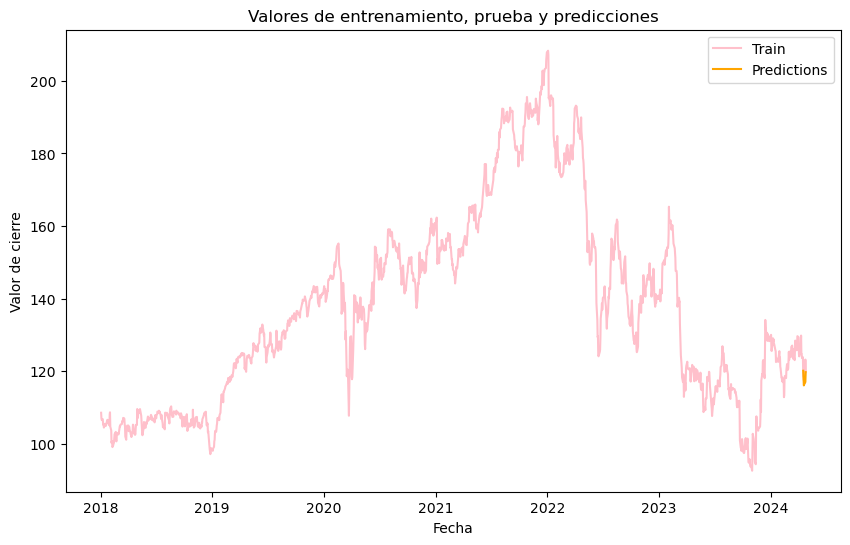

In [75]:
plt.figure(figsize=(10, 6))

plt.plot(full_data_glr['date'], full_data_glr['high'], label='Train', color='pink')

plt.plot(full_data_glr['date'], full_data_glr['predictions'], label='Predictions', color='orange')

plt.xlabel('Fecha')
plt.ylabel('Valor de cierre')
plt.title('Valores de entrenamiento, prueba y predicciones')
plt.legend()

plt.show()

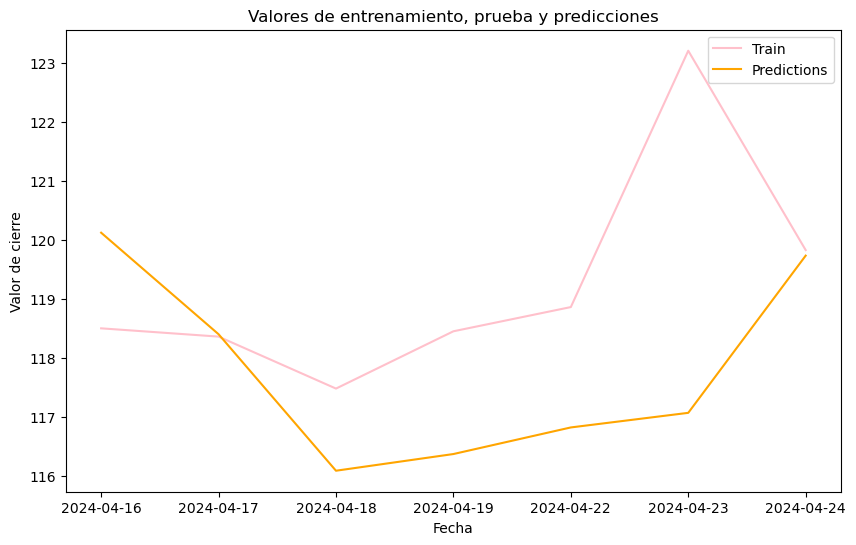

In [76]:
test_pd_glr = test_pd_glr.sort_values('date')

plt.figure(figsize=(10, 6))

plt.plot(test_pd_glr['date'], test_pd_glr['high'], label='Train', color='pink')

plt.plot(test_pd_glr['date'], test_pd_glr['predictions'], label='Predictions', color='orange')

plt.xlabel('Fecha')
plt.ylabel('Valor de cierre')
plt.title('Valores de entrenamiento, prueba y predicciones')
plt.legend()

plt.show()

In [ ]:
spark.stop()